In [2]:
!pip install torch torchvision --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pytorch Image Classifier-CNN

Lookup UResnet structure.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)


Device available:  cpu


In [ ]:
## Access training data, configure and check for uniformity and if transform needed

filepath = # test with local, then structure Supabase link

# if images stored separately, join together with csv
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  #print(i)
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    #print(label)
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      #print(image)
      labels.append(label)

data_df = pd.DataFrame(columns = ["filename", "PV"])
data_df.head()

# print image to check working
# make sure all images standard size and RGB-enabled 


Build filepaths for nested images in different folders:
root/
    images/
        8/
            AZ_98.png
            AZ_184.png

In [2]:
df = pd.read_csv("C:/Users/Owner/Downloads/All_TIF_labeled_tiles.csv")

root_dir = "C:/Users/Owner/Documents/MADS/Capstone/Data/AZ/2015/CNN_png"

df['filepath'] = df.apply(
    lambda row: os.path.join(root_dir, str(row['File'])),
    axis=1
)

# Map filenames to full filepaths

image_dir = "C:/Users/Owner/Documents/MADS/Capstone/Data/AZ/2015/CNN_png"

In [3]:
# Map filenames to full filepaths

#image_dir = "C:/Users/Owner/Documents/MADS/Capstone/Data/AZ/2015/CNN_png"

#df['filepath'] = df['filename'].apply(lambda x: os.path.join(image_dir, x))

# Sanity check for missing files
missing = df[~df['filepath'].apply(os.path.exists)]
print("Missing files:", missing)

# If pulling from single folder
#image_dir = "C:/Users/Owner/Documents/MADS/Capstone/Data/AZ/2015/CNN_png"

#df['filepath'] = df['File'].apply(lambda x: os.path.join(image_dir, x))

Missing files: Empty DataFrame
Columns: [File, Num_roofs, Has_roofs, R/C, PV, Azimuth, Folder, filepath]
Index: []


### Labels and how they should be encoded

|Label	|Type	|Description	|Encoding|
|:------|:------|:--------------|:-------|
|Num_roofs|Regression|Integer|count(Keep as float)|
|Has_roof|Binary classification|0/1	|Keep as 0 or 1|
|R/C|3-class classification|R, C, or null|Map → R=0, C=1, NULL=2|
|PV|Binary classification|0/1|Keep as 0 or 1|
|Azimuth|9-class classification|{N, NE, E, SE, S, SW, W, NW, 0}|Map to 0–8|

This is a classic multi-head CNN problem.

In [4]:
# Clean and encode labels

# Residential/Commercial class
# Option 1-binary
# Still has Nans, interferes with dtype(long) broadcasting
#df['R/C'] = df['R/C'].str.strip().map({'R': 0, 'C': 1})

# Option 2-3 categories, since there are images with neither R nor C
# Still has strings, interferes with dtype(long) broadcasting
#df['R/C'] = df['R/C'].replace({
#    'R': 0,
#    'C': 1,
#    None: 2,
#    pd.NA: 2,
#    float('nan'): 2
#})

# Option 2b
df['R/C'] = df['R/C'].map({'R': 0, 'C': 1}).fillna(2).astype(int)

# Option 3-null is included as a separate category
#df['R/C'] = df['R/C'].map({'R': 0, 'C': 1}).fillna(-1).astype(int)

# Azimuth class
azimuth_map = {
    'N': 0, 'NE': 1, 'E': 2, 'SE': 3,
    'S': 4, 'SW': 5, 'W': 6, 'NW': 7,
    '0': 8, 0: 8
}

df['Azimuth'] = df['Azimuth'].astype(str).map(azimuth_map)

In [6]:
train = df.sample(frac=0.7)
test = df.drop(train.index)
val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(386, 8)
(83, 8)
(83, 8)


In [7]:
#label_encoder = LabelEncoder()
#label_encoder.fit(data_df['labels'])    # PV already binary, use for Res/Comm

# may not need all these transforms, check image sizes first
transform = transforms.Compose([
  transforms.Resize((120, 120)),
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float32)
])

In [ ]:
# See if we need to normalize the images
# Create transforms for training images

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
# Each output must be returned separately because they use different loss functions.
# Version 3-Dataset class

class RoofDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # image
        img = Image.open(row['filepath']).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # labels
        num_roofs  = torch.tensor(row['Num_roofs'], dtype=torch.float32)
        has_roofs  = torch.tensor(row['Has_roofs'], dtype=torch.long)
        rc_class   = torch.tensor(row['R/C'], dtype=torch.long)
        pv_class   = torch.tensor(row['PV'], dtype=torch.long)
        azimuth    = torch.tensor(row['Azimuth'], dtype=torch.long)

        return img, {
            "num_roofs": num_roofs,      # regression
            "has_roofs": has_roofs,      # binary class
            "rc_class": rc_class,        # 3-class
            "pv_class": pv_class,        # binary class
            "azimuth": azimuth           # 9-class
        }

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(image_path).convert("RGB")
    if self.transform:
      image = self.transform(image)

    return image, label

In [10]:
train_dataset = RoofDataset(train, transform)
test_dataset = RoofDataset(test, transform)
val_dataset = RoofDataset(val, transform)

In [9]:
train_dataset = CustomImageDataset(train, transform)
test_dataset = CustomImageDataset(test, transform)
val_dataset = CustomImageDataset(val, transform)

NameError: name 'CustomImageDataset' is not defined

In [11]:
# check to make sure it's working
train_dataset.__getitem__(2)

(tensor([[[0.2667, 0.2745, 0.2706,  ..., 0.5882, 0.6627, 0.8235],
          [0.3216, 0.3255, 0.3255,  ..., 0.5961, 0.6510, 0.7961],
          [0.4000, 0.4039, 0.4000,  ..., 0.6980, 0.7333, 0.7686],
          ...,
          [0.3961, 0.3961, 0.4078,  ..., 0.3333, 0.3333, 0.3412],
          [0.4549, 0.4588, 0.4706,  ..., 0.3373, 0.3373, 0.3412],
          [0.6980, 0.6902, 0.5686,  ..., 0.3412, 0.3412, 0.3451]],
 
         [[0.2784, 0.2824, 0.2784,  ..., 0.5451, 0.6235, 0.7882],
          [0.3333, 0.3373, 0.3373,  ..., 0.5490, 0.6039, 0.7608],
          [0.4078, 0.4157, 0.4118,  ..., 0.6549, 0.6902, 0.7216],
          ...,
          [0.4078, 0.4118, 0.4157,  ..., 0.3725, 0.3804, 0.3843],
          [0.4706, 0.4745, 0.4863,  ..., 0.3725, 0.3804, 0.3882],
          [0.7216, 0.7176, 0.5843,  ..., 0.3765, 0.3843, 0.3882]],
 
         [[0.3098, 0.3176, 0.3059,  ..., 0.5020, 0.5804, 0.7490],
          [0.3490, 0.3490, 0.3451,  ..., 0.5020, 0.5569, 0.7137],
          [0.4196, 0.4157, 0.4118,  ...,

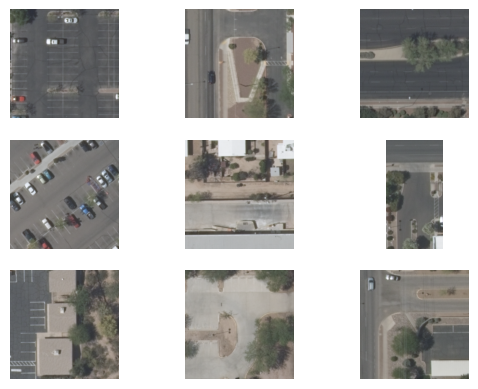

In [13]:
#Optional check: visualize the images
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["filepath"].iloc[0]).convert(("RGB"))
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

In [14]:
lr = 1e-4
batch_size = 16
epochs = 16
        

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Create DataLoader

dataset = RoofDataset(df, transform=train_tfms)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Think about which labels should be predicted from the CNN and how they are generated.

Single-target classification
(e.g., predict Has_roofs)

Single-target regression
(e.g., predict Num_roofs)

Multi-label classification
(Has_roofs, R/C, PV, etc.)

Full multi-output CNN
regression + classification mixed

In [ ]:
# You should use a CNN backbone (ResNet18 is a great start).
# Then create 5 heads:
# - one regression head
# - four classification heads

class MultiOutputCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # backbone
        self.base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_feats = self.base.fc.in_features
        self.base.fc = nn.Identity()

        # heads
        self.num_roofs = nn.Linear(in_feats, 1)      # regression
        self.has_roofs = nn.Linear(in_feats, 2)      # binary class
        self.rc_class  = nn.Linear(in_feats, 3)      # 3 classes
        self.pv_class  = nn.Linear(in_feats, 2)      # binary class
        self.azimuth   = nn.Linear(in_feats, 9)      # 9 classes

    def forward(self, x):
        feats = self.base(x)

        return {
            "num_roofs": self.num_roofs(feats),
            "has_roofs": self.has_roofs(feats),
            "rc_class": self.rc_class(feats),
            "pv_class": self.pv_class(feats),
            "azimuth": self.azimuth(feats)
        }

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    # Calculate the correct input size for the linear layer
    # After conv3 and pool, the spatial dimensions are 120 / (2*2*2) = 15
    # The number of channels is 128. Previously 128*16*16
    self.linear = nn.Linear(in_features=128*15*15, out_features=128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)   # what is the next part? -->32, 128, 128
    x = self.pool(x)    # -->32, 64, 64
    x = self.relu(x)

    x = self.conv2(x)   # what is the next part? --> 64, 64, 64
    x = self.pool(x)    # --64, 32, 32
    x = self.relu(x)

    x = self.conv3(x)   # what is the next part? --> 128, 32, 32
    x = self.pool(x)    # --128, 16, 16
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [17]:
model = MultiOutputCNN().to(device)
#model = Net().to(device)

NameError: name 'models' is not defined

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 120, 120))

### Loss Functions 

We need mixed loss types for our outputs.

|Output	|Loss	|
|:------|:------|
|Num_roofs|MSELoss|
|Has_roof|CrossEntropyLoss|
|R/C|CrossEntropyLoss|
|PV|CrossEntropyLoss|
|Azimuth|CrossEntropyLoss|

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)   # need to check for crossfold validation integration
criterion_mse = nn.MSELoss()

In [ ]:
total_loss_train_plot = []
total_loss_test_plot = []
total_loss_val_plot = []

total_acc_train_plot = []
total_acc_test_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/len(train_loader.dataset), 4))
  total_loss_val_plot.append(round(total_loss_val/len(val_loader.dataset), 4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100, 4))
  total_acc_val_plot.append(round((total_acc_val/val_dataset.__len__()) * 100, 4))

  print(f'''Epoch: {epoch+1}/{epochs}
        Train Loss: {round(total_loss_train/len(train_loader.dataset), 4)}
        Train Acc: {round((total_acc_train/train_dataset.__len__()) * 100, 4)}
        Val Loss: {round(total_loss_val/len(val_loader.dataset), 4)}
        Val Acc: {round((total_acc_val/val_dataset.__len__()) * 100, 4)}''')

In [ ]:
# Training Loop

for imgs, labels in loader:
    imgs = imgs.to(device)

    # forward
    outputs = model(imgs)

    # losses
    loss_num  = criterion_mse(outputs["num_roofs"].squeeze(), labels["num_roofs"].to(device))
    loss_has  = criterion_ce(outputs["has_roofs"], labels["has_roofs"].to(device))
    loss_rc   = criterion_ce(outputs["rc_class"], labels["rc_class"].to(device))
    loss_pv   = criterion_ce(outputs["pv_class"], labels["pv_class"].to(device))
    loss_az   = criterion_ce(outputs["azimuth"], labels["azimuth"].to(device))

    # total loss (you may weight these later)
    loss = loss_num + loss_has + loss_rc + loss_pv + loss_az

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += acc

    loss = criterion(predictions, labels)
    total_loss_test += loss.item()

  print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/len(test_loader.dataset), 4)}")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(total_loss_train_plot, label="Train Loss")
axes[0].plot(total_loss_val_plot, label="Val Loss")
axes[0].set_title("Training and Validation Loss over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(total_acc_train_plot, label="Train Acc")
axes[1].plot(total_acc_val_plot, label="Val Acc")
axes[1].set_title("Accuracy over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

### Troubleshooting for poor results

1. Should Num_roofs be normalized?

May need to add scaling logic

2. Should we weight the 5 losses differently?

Right now all tasks have equal weight.

3. Are the images different resolutions?

If so, adjust transforms.